# 데이터 로드

In [2]:
from scipy.io import arff
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten, MaxPooling1D, BatchNormalization, Dropout, TimeDistributed, Conv1D, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau


from time import time
data, meta = arff.loadarff('./dataset/FordA_TRAIN.arff')
df = pd.DataFrame(data)

data, meta = arff.loadarff('./dataset/FordA_TEST.arff')
df1 = pd.DataFrame(data)
df

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att492,att493,att494,att495,att496,att497,att498,att499,att500,target
0,-0.797172,-0.664392,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251,1.640809,...,0.722417,0.362068,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.073796,-1.564343,b'-1'
1,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,-1.619951,...,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086,b'1'
2,0.727985,0.111284,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211,-2.550600,...,0.463685,0.507735,0.517174,0.504588,0.476270,0.438513,0.394463,0.339400,0.255391,b'-1'
3,-0.234439,-0.502157,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430,-1.506933,...,-0.929437,-0.922761,-0.929437,-0.909409,-0.835970,-0.695768,-0.478790,-0.188707,0.119736,b'-1'
4,-0.171328,-0.062285,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751,1.466467,...,0.725496,0.697453,0.731967,0.808545,0.839823,0.733046,0.437520,-0.026585,-0.602213,b'-1'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,0.196022,-0.070102,-0.336226,-0.516799,-0.555282,-0.442793,-0.221369,0.025217,0.233320,0.350545,...,1.129082,0.528158,-0.039020,-0.573043,-1.061479,-1.514392,-1.934743,-2.316612,-2.603753,b'-1'
3597,0.041994,0.422255,0.740529,0.975426,1.109891,1.137270,1.058349,0.894955,0.671224,0.421544,...,-0.392667,-0.333749,-0.316543,-0.340299,-0.392876,-0.450805,-0.482609,-0.467769,-0.393755,b'1'
3598,-0.570054,-0.333165,-0.293519,-0.425344,-0.590869,-0.615648,-0.348033,0.275412,1.153586,2.035725,...,0.579700,0.157463,-0.353980,-0.885246,-1.314421,-1.512655,-1.393714,-0.942733,-0.270722,b'-1'
3599,2.006732,2.079150,2.022036,1.867560,1.648112,1.379446,1.093717,0.784057,0.434150,0.029284,...,1.148971,0.928088,0.634953,0.311682,-0.007376,-0.270543,-0.432145,-0.441231,-0.280709,b'1'


# 데이터 상관 계수 분석

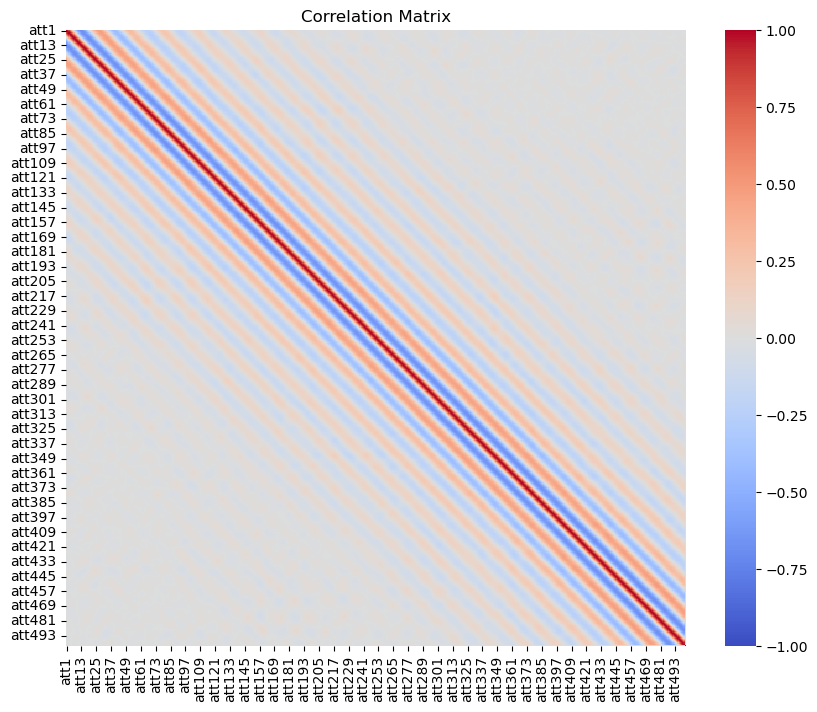

In [4]:
# 상관 행렬 계산
corr = df.corr()

# 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1, annot=False)
plt.title('Correlation Matrix')
plt.show()

# 상관 관계 분석 및 시각화 - 히트맵을 통해 근처 센서간의 연관성 높다는 것 파악가능하다.
# ==> 음의 상관계수 : 
# !!!!!!!특성 숫자가 나타내는 것이 무엇인지? (가능하면 파악하기)!!!!!!!!!

# 데이터 전처리

In [7]:
from scipy.io.arff import loadarff

# ARFF 파일을 읽어서 2D numpy 배열로 변환하는 함수 (후속 데이터 분석이나 모델 학습에 이용하기 위해)
def read_ariff(path):
    
    raw_data, meta =loadarff(path)
    # 메타데이터에서 칼럼 이름 추출
    cols=[x for x in meta]
    # 빈 2D 배열 생성
    data2d=np.zeros([raw_data.shape[0],len(cols)])
    # 칼럼 순회하며 데이터 할당
    for i,col in zip(range(len(cols)),cols): 
        data2d[:,i]=raw_data[col]
        
    return data2d


train_path="./dataset/FordA_TRAIN.arff"
test_path="./dataset/FordA_TEST.arff"

data2d=read_ariff(train_path)
test2d=read_ariff(test_path)
print(data2d.shape, test2d.shape)


(3601, 501) (1320, 501)


# 정상/비정상 데이터 시각화

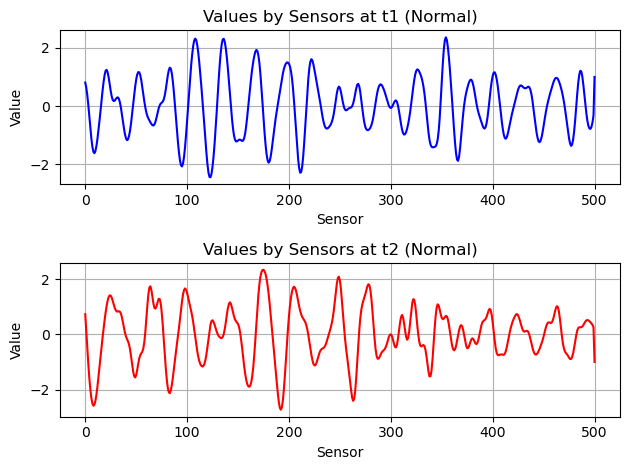

In [70]:
# 첫 번째 subplot: t1 시간대 (data2d[1, :])
plt.subplot(2, 1, 1)  # 2행 1열 중 첫 번째 subplot
plt.plot(data2d[1, :], linestyle='-', color='b')
plt.xlabel('Sensor')
plt.ylabel('Value')
plt.title('Values by Sensors at t1 (Normal)')
plt.grid(True)  # 그리드 추가

# 두 번째 subplot: t2 시간대 (data2d[2, :])
plt.subplot(2, 1, 2)  # 2행 1열 중 두 번째 subplot
plt.plot(data2d[2, :],  linestyle='-', color='r')
plt.xlabel('Sensor')
plt.ylabel('Value')
plt.title('Values by Sensors at t2 (Normal)')
plt.grid(True)  # 그리드 추가


# 전체 그래프 설정
# plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['axes.unicode_minus'] = False

plt.tight_layout()  # 레이아웃 조정
plt.show()

# 불량, 정상 샘픔을 비슷한 비율로 학습 데이터와 검증 데이터로 분류 코드

In [16]:
# 배열을 생성하여 불량, 정상 샘플을 분류
abnormal=data2d[data2d[:,-1]==1]
normal=data2d[data2d[:,-1]==-1]
print(abnormal.shape, normal.shape)

train2d=np.concatenate((abnormal[:int(0.8*abnormal.shape[0])],
                       normal[:int(0.8*abnormal.shape[0])]),
                       axis=0)

val2d=np.concatenate((abnormal[int(0.8*abnormal.shape[0]):],
                       normal[int(0.8*abnormal.shape[0]):]),
                       axis=0)

np.random.shuffle(train2d)
np.random.shuffle(val2d)

print(train2d.shape, val2d.shape)

(1755, 501) (1846, 501)
(2808, 501) (793, 501)


불량         정상
(1755, 501) (1846, 501)
학습         검증
(2808, 501) (793, 501)


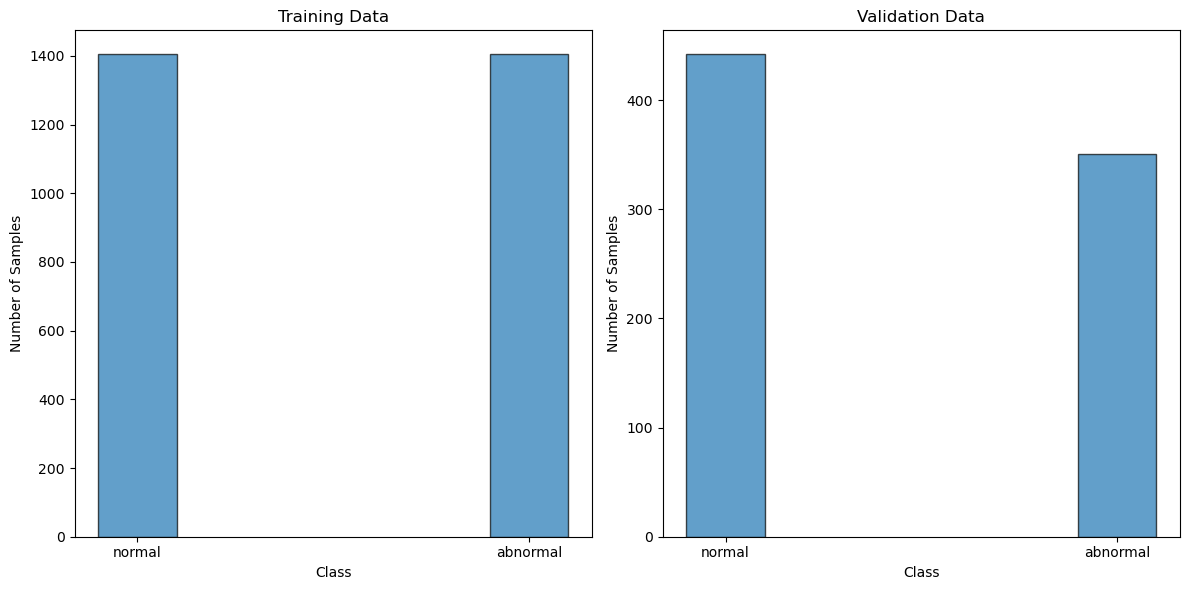

In [92]:
import numpy as np
import matplotlib.pyplot as plt

# 불량 및 정상 샘플을 분리
abnormal = data2d[data2d[:, -1] == 1]
normal = data2d[data2d[:, -1] == -1]
print('불량         정상')
print(abnormal.shape, normal.shape)

# 학습 데이터와 검증 데이터 분할
train2d = np.concatenate((abnormal[:int(0.8 * abnormal.shape[0])],
                          normal[:int(0.8 * abnormal.shape[0])]),
                         axis=0)

val2d = np.concatenate((abnormal[int(0.8 * abnormal.shape[0]):],
                        normal[int(0.8 * abnormal.shape[0]):]),
                       axis=0)

# 데이터를 무작위로 섞기
np.random.shuffle(train2d)
np.random.shuffle(val2d)

print('학습         검증')
print(train2d.shape, val2d.shape)

# 학습 데이터와 검증 데이터의 정상 및 불량 샘플 수 시각화
train_labels = train2d[:, -1]
val_labels = val2d[:, -1]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# 학습 데이터 시각화
unique, counts = np.unique(train_labels, return_counts=True)
axs[0].bar(unique, counts, width=0.4, edgecolor='k', alpha=0.7)
axs[0].set_title('Training Data')
axs[0].set_xticks([1, -1])
axs[0].set_xticklabels(['abnormal', 'normal'])
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Number of Samples')

# 검증 데이터 시각화
unique, counts = np.unique(val_labels, return_counts=True)
axs[1].bar(unique, counts, width=0.4, edgecolor='k', alpha=0.7)
axs[1].set_title('Validation Data')
axs[1].set_xticks([1, -1])
axs[1].set_xticklabels(['abnormal', 'normal'])
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Number of Samples')

plt.tight_layout()
plt.show()


불량         정상
(1755, 501) (1846, 501)
학습         검증
(2808, 501) (793, 501)


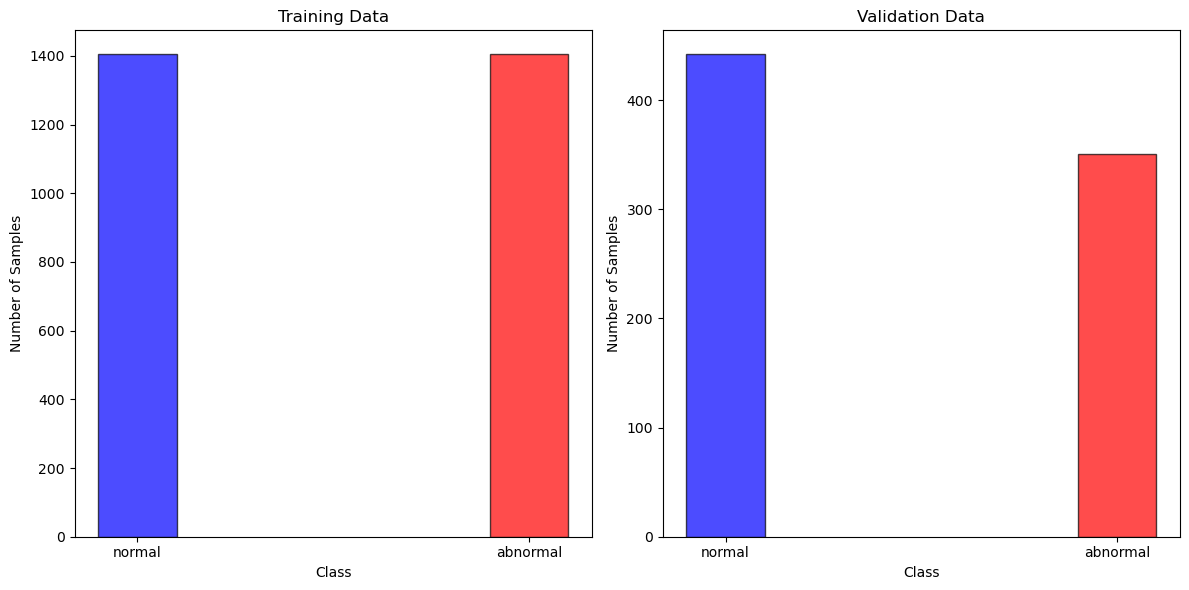

In [93]:
import numpy as np
import matplotlib.pyplot as plt

# 불량 및 정상 샘플을 분리
abnormal = data2d[data2d[:, -1] == 1]
normal = data2d[data2d[:, -1] == -1]
print('불량         정상')
print(abnormal.shape, normal.shape)

# 학습 데이터와 검증 데이터 분할
train2d = np.concatenate((abnormal[:int(0.8 * abnormal.shape[0])],
                          normal[:int(0.8 * abnormal.shape[0])]),
                         axis=0)

val2d = np.concatenate((abnormal[int(0.8 * abnormal.shape[0]):],
                        normal[int(0.8 * abnormal.shape[0]):]),
                       axis=0)

# 데이터를 무작위로 섞기
np.random.shuffle(train2d)
np.random.shuffle(val2d)

print('학습         검증')
print(train2d.shape, val2d.shape)

# 학습 데이터와 검증 데이터의 정상 및 불량 샘플 수 시각화
train_labels = train2d[:, -1]
val_labels = val2d[:, -1]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# 학습 데이터 시각화
unique, counts = np.unique(train_labels, return_counts=True)
colors = ['red' if x == 1 else 'blue' for x in unique]
axs[0].bar(unique, counts, width=0.4, edgecolor='k', alpha=0.7, color=colors)
axs[0].set_title('Training Data')
axs[0].set_xticks([1, -1])
axs[0].set_xticklabels(['abnormal', 'normal'])
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Number of Samples')

# 검증 데이터 시각화
unique, counts = np.unique(val_labels, return_counts=True)
colors = ['red' if x == 1 else 'blue' for x in unique]
axs[1].bar(unique, counts, width=0.4, edgecolor='k', alpha=0.7, color=colors)
axs[1].set_title('Validation Data')
axs[1].set_xticks([1, -1])
axs[1].set_xticklabels(['abnormal', 'normal'])
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Number of Samples')

plt.tight_layout()
plt.show()


# 데이터 정규화 (Scaling the data)

In [21]:
# 2D 데이터를 3D 데이터로 변환하는 함수 (LSTM을 하기 위해)
def make3d(data):
    df=data.copy()
    x,y=df.shape
    data3d=np.zeros([x,y-1,2])
    
    for i in range(x):
        data3d[i,:,0]=df[i][:-1].T
        data3d[i,:,1]=np.full((y-1),df[i][-1])
        
    return data3d

train3d=make3d(train2d)
val3d  =make3d(val2d)
test3d =make3d(test2d)

def scale_d(data):
    df=data.copy()
    df_scaled=np.zeros(df.shape)
    stder = StandardScaler()
    
    for i in range(df.shape[0]):
        df_scaled[i,:,0]=stder.fit_transform(
                                         df[i,:,0].reshape((df.shape[1], 1))
                                         ).reshape((df.shape[1]))
        df_scaled[i,:,1]=df[i,:,1]
        
    return df_scaled

train_scaled=scale_d(train3d)
val_scaled  =scale_d(val3d)
test_scaled =scale_d(test3d)

x_train = np.expand_dims(train_scaled[:,:,0],axis=2)
x_val   =np.expand_dims(val_scaled[:,:,0],axis=2)
x_test  =np.expand_dims(test_scaled[:,:,0],axis=2)

y_train  =train_scaled[:,:,1]
y_val   =val_scaled[:,:,1]
y_test  =test_scaled[:,:,1]

y_train_e=np.expand_dims(y_train,axis=2)
y_val_e =np.expand_dims(y_val,axis=2)
y_test_e=np.expand_dims(y_test,axis=2)

y_train_s=y_train[:,0]
y_train_s=np.array([1. if x==1 else 0. for x in y_train[:,0]])

y_val_s =y_val[:,0]
y_val_s=np.array([1. if x==1 else 0. for x in y_val[:,0]])

y_test_s=y_test[:,0]
y_test_s=np.array([1. if x==1 else 0. for x in y_test[:,0]])

print(x_train.shape,x_val.shape,x_test.shape)

print(y_train.shape,y_val.shape,y_test.shape)
print()
print(y_train_e.shape,y_val_e.shape,y_test_e.shape)

print(y_train_s.shape,y_val_s.shape,y_test_s.shape)


(2808, 500, 1) (793, 500, 1) (1320, 500, 1)
(2808, 500) (793, 500) (1320, 500)

(2808, 500, 1) (793, 500, 1) (1320, 500, 1)
(2808,) (793,) (1320,)


Batch genereator function 

In [12]:
# # 시퀀스 형태의 데이터 생성
# def batch_generator(data_x,data_y,sequence_length):
#     """
#     Generator function for creating random batches of training-data.
#     """
#     df_x=data_x.copy()
#     df_y=data_y.copy()
#     # Infinite loop.
#     while True:
#         # Allocate a new array for the batch of input-signals.
#         x_shape = (df_x.shape[0], sequence_length, df_x.shape[2])
#         x_batch = np.zeros(shape=x_shape, dtype=np.float16)

#         # Allocate a new array for the batch of output-signals.
#         y_shape = (df_y.shape[0], sequence_length, df_y.shape[2])
#         y_batch = np.zeros(shape=y_shape, dtype=np.float16)

#         # Fill the batch with random sequences of data.
#         for i in range(df_x.shape[0]):
#             # Get a random start-index.
#             # This points somewhere into the training-data.
#             idx = np.random.randint(df_x.shape[1] - sequence_length)
# #             print(idx,idx+sequence_length)
#             # Copy the sequences of data starting at this index.
#             x_batch[i] = df_x[i,idx:idx+sequence_length,:]
#             y_batch[i] = df_y[i,idx:idx+sequence_length,:]
        
#         yield (x_batch, y_batch)


# # 시퀀스와 이진 출력 형태의 데이터 생성
# def batch_generator_s(data_x,data_y,sequence_length):
#     """
#     Generator function for creating random batches of training-data.
#     """
#     df_x=data_x.copy()
#     df_y=data_y.copy()
#     # Infinite loop.
#     while True:
#         # Allocate a new array for the batch of input-signals.
#         x_shape = (df_x.shape[0], sequence_length, df_x.shape[2])
#         x_batch = np.zeros(shape=x_shape, dtype=np.float16)

#         # Allocate a new array for the batch of output-signals.
#         y_shape = (df_y.shape[0], 1)
#         y_batch = np.zeros(shape=y_shape, dtype=np.float16)

#         # Fill the batch with random sequences of data.
#         for i in range(df_x.shape[0]):
#             # Get a random start-index.
#             # This points somewhere into the training-data.
#             idx = np.random.randint(df_x.shape[1] - sequence_length)
# #             print(idx,idx+sequence_length)
#             # Copy the sequences of data starting at this index.
#             x_batch[i] = df_x[i,idx:idx+sequence_length,:]
#         y_batch = df_y
        
#         yield (x_batch, y_batch)
        


Function to load best callback

In [13]:
# import warnings

# class GetBest(Callback):

#     def __init__(self, monitor='val_loss', verbose=0,
#                  mode='auto', period=1):
#         super(GetBest, self).__init__()
#         self.monitor = monitor
#         self.verbose = verbose
#         self.period = period
#         self.best_epochs = 0
#         self.epochs_since_last_save = 0

#         if mode not in ['auto', 'min', 'max']:
#             warnings.warn('GetBest mode %s is unknown, '
#                           'fallback to auto mode.' % (mode),
#                           RuntimeWarning)
#             mode = 'auto'

#         if mode == 'min':
#             self.monitor_op = np.less
#             self.best = np.Inf
#         elif mode == 'max':
#             self.monitor_op = np.greater
#             self.best = -np.Inf
#         else:
#             if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
#                 self.monitor_op = np.greater
#                 self.best = -np.Inf
#             else:
#                 self.monitor_op = np.less
#                 self.best = np.Inf
                
#     def on_train_begin(self, logs=None):
#         self.best_weights = self.model.get_weights()

#     def on_epoch_end(self, epoch, logs=None):
#         logs = logs or {}
#         self.epochs_since_last_save += 1
#         if self.epochs_since_last_save >= self.period:
#             self.epochs_since_last_save = 0
#             #filepath = self.filepath.format(epoch=epoch + 1, **logs)
#             current = logs.get(self.monitor)
#             if current is None:
#                 warnings.warn('Can pick best model only with %s available, '
#                               'skipping.' % (self.monitor), RuntimeWarning)
#             else:
#                 if self.monitor_op(current, self.best):
#                     if self.verbose > 0:
#                         print('\nEpoch %05d: %s improved from %0.5f to %0.5f,'
#                               ' storing weights.'
#                               % (epoch + 1, self.monitor, self.best,
#                                  current))
#                     self.best = current
#                     self.best_epochs = epoch + 1
#                     self.best_weights = self.model.get_weights()
#                 else:
#                     if self.verbose > 0:
#                         print('\nEpoch %05d: %s did not improve' %
#                               (epoch + 1, self.monitor))            
                    
#     def on_train_end(self, logs=None):
#         if self.verbose > 0:
#             print('Using epoch %05d with %s: %0.5f' % (self.best_epochs, self.monitor,
#                                                        self.best))
#         self.model.set_weights(self.best_weights)

# ROC 곡선 함수

In [ ]:
def draw_roc_keras(model, xt, yt):
    # 예측값 생성
    predictions = model.predict(xt)
    # 이진 분류 조정: 예측 값이 두 클래스의 확률일 경우, 긍정 클래스의 확률을 선택
    # => ROC 곡선을 그릴 때 주로 긍정 클래스에 대한 성능을 평가
    if predictions.shape[1] == 2:
        predictions = predictions[:, 1] # 긍정 클래스가 두 번째 클래스

    # ROC 곡선 계산: 실제 라벨 'yt'과 예측 확률을 사용하여 FPR(위양성률), TPF(진양성률), 임계값을 계산
    fpr, tpr, thr = roc_curve(yt, predictions)
    # AUC 계산 (1에 가까울수록 성능이 좋음)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    # ROC 곡선 그리기
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return predictions


# LSTM (Long Short-Term Memory) 
- 시계열 데이터를 이진 분류하는 작업 수행

/Users/1tae/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 500, 100)       │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 50000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 100)            │     5,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,041,001 (19.23 MB)

 Trainable params: 5,041,001 (19.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5640 - loss: 0.7397Epoch 1: val_accuracy improved to 0.64187
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.5650 - loss: 0.7383 - val_accuracy: 0.6419 - val_loss: 0.6406
Epoch 2/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6991 - loss: 0.5992Epoch 2: val_accuracy improved to 0.67465
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6994 - loss: 0.5987 - val_accuracy: 0.6747 - val_loss: 0.6145
Epoch 3/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7066 - loss: 0.5619 - val_accuracy: 0.6683 - val_loss: 0.6512
Epoch 4/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7482 - loss: 0.5420 - val_accuracy: 0.6242 - val_loss: 0.8200
Epoch 5/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7808 - loss: 0.4935 - val_accuracy: 0.6709 - val_loss: 0.6395
Epoch 6/60
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7853 - loss: 0.4659Epoch 6: val_accuracy improved to 0.69231
50/50 ━━━

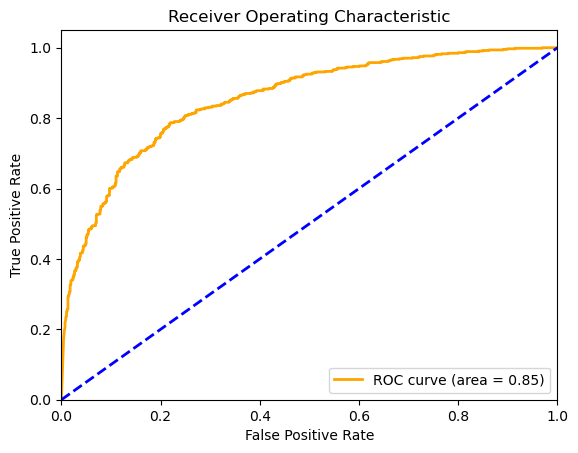

compile_metrics: 77.58%


In [35]:
# 배치 생성기 (x, y 데이터를 받아서 주어진 배치 크기로 분할하여 생성)
def batch_generator_s(x, y, seq_len, batch_size=32):
    num_samples = len(x)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_x = x[offset:offset+batch_size, :seq_len, :]
            batch_y = y[offset:offset+batch_size]
            yield batch_x, batch_y


# 하이퍼파라미터 설정
seq_len = 500 # 입력 시퀀스의 길이
STEPS = 50 # 각 epoch당 배치 개수
EPOCHS = 60 # 학습 epochs 수

model_d = Sequential()

model_d.add(LSTM(units=100, # LSTM 층을 추가하여 100개의 유닛을 사용
                 return_sequences=True, # 각 타임스텝의 출력을 다음 층으로 전달                     !!!! (시계열 데이터 이기 떄문에 중요해보임)
                 input_shape=(seq_len, 1)))

model_d.add(Flatten()) # 다차원 출력을 1차원으로 변환
model_d.add(Dense(100, activation='relu')) # relu 활성화 함수 사용
model_d.add(Dense(1, activation='sigmoid')) # 이진 분류를 위한 sigmoid 활성화 함수 사용

model_d.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_d.summary()

NAME = f"td_fordA-{seq_len}seq_{int(time())}" # 모델 이름 설정
# 데이터 준비
# x_train, y_train_s, x_val, y_val_s, x_test, y_test_s 변수가 정의되어 있다고 가정
gen_train = batch_generator_s(x_train, y_train_s, seq_len)
gen_val = batch_generator_s(x_val, y_val_s, seq_len)

tensorboard = TensorBoard(log_dir='Logs/{}'.format(NAME)) # 학습 로그 기록

# 검증 손실이 가장 낮을 때 모델 가중치 저장
checkp = ModelCheckpoint('./LSTM_best.weights.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')

# callback 설정(학습 도중 가장 높은 검증 정확도를 기록)
class GetBest(Callback):
    def __init__(self, monitor='val_accuracy', verbose=1, mode='max'):
        super(GetBest, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.mode = mode
        self.best = -np.Inf if mode == 'max' else np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if self.mode == 'max':
            if current > self.best:
                self.best = current
                if self.verbose:
                    print(f'Epoch {epoch+1}: {self.monitor} improved to {self.best:.5f}')
        else:
            if current < self.best:
                self.best = current
                if self.verbose:
                    print(f'Epoch {epoch+1}: {self.monitor} improved to {self.best:.5f}')

best = GetBest(monitor='val_accuracy', verbose=1, mode='max')

callbacks = [best, tensorboard, checkp]

# 모델 학습
model_d.fit(gen_train,
            epochs=EPOCHS,
            steps_per_epoch=STEPS,
            validation_data=gen_val,
            validation_steps=STEPS,
            callbacks=callbacks)

# 모델 평가
scores = model_d.evaluate(x_test[:, :seq_len, :], y_test_s, verbose=0)
print("%s: %.2f%%" % (model_d.metrics_names[1], scores[1] * 100))

pred = draw_roc_keras(model_d, x_test[:, :seq_len, :], y_test_s)
print("%s: %.2f%%" % (model_d.metrics_names[1], scores[1] * 100))


# test
- 테스트 데이터 배치에 대한 평가를 수행하고, 각 배치의 정확도를 출력하는 작업을 수행하고, 각 배치의 정확도를 출력하는 작업

In [36]:
# gen_test =batch_generator_s(x_test,y_test_s,seq_len)
# for i in range(100):
#     x_batch, y_batch= next(gen_test)
#     scores = model_d.evaluate([x_batch], y_batch, verbose=0)
#     print("%s: %.2f%%" % (model_d.metrics_names[1], scores[1]*100))
# #     pred=draw_roc_keras(model_d,[x_batch],y_batch)

In [37]:
# accuracies = []
# for i in range(100):
#     x_batch, y_batch = next(gen_test)
#     scores = model_d.evaluate([x_batch], y_batch, verbose=0)
#     accuracies.append(scores[1] * 100)
#     print("%s: %.2f%%" % (model_d.metrics_names[1], scores[1] * 100))

# average_accuracy = np.mean(accuracies)
# print("Average Accuracy: %.2f%%" % average_accuracy)


# 테스트 데이터를 이용한 정확도 평균

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
compile_metrics: 71.88%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
compile_metrics: 75.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
compile_metrics: 71.88%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
compile_metrics: 87.50%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
compile_metrics: 65.62%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
compile_metrics: 65.62%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
compile_metrics: 71.88%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
compile_metrics: 65.62%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
compile_metrics: 78.12%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
compile_metrics: 50.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
compile_metrics: 78.12%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
compile_metrics: 78.12%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
compile_metrics: 56.25%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
compile_metrics: 75.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
compile_metrics: 75.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
compile_metrics: 65.62%
1/1 ━━━━━━━━━

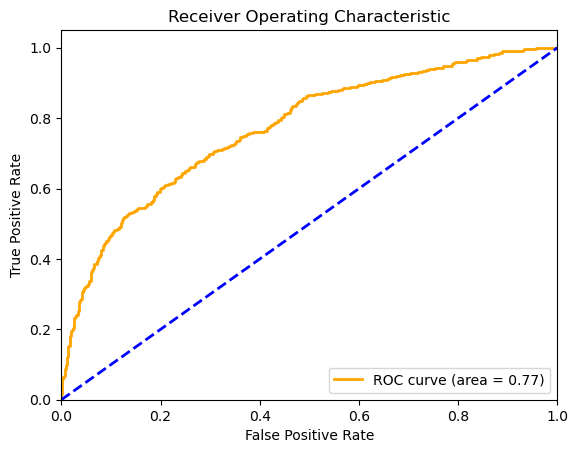

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc


# 하이퍼파라미터 설정
seq_len = 500 # 입력 시퀀스의 길이
STEPS = 50 # 각 epoch당 배치 개수
EPOCHS = 60 # 학습 epochs 수

# 모델 정의
def create_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# 모델 인스턴스 생성 및 가중치 로드
model = create_model((seq_len, 1))
model.load_weights('LSTM_best.weights.h5')

# 테스트 데이터 준비
gen_test = batch_generator_s(x_test, y_test_s, seq_len)

# 테스트 배치 평가
accuracies = []
predictions = []
true_labels = []

for i in range(100):  # 원하는 배치 수
    x_batch, y_batch = next(gen_test)
    scores = model.evaluate([x_batch], y_batch, verbose=0)
    accuracies.append(scores[1] * 100)
    batch_preds = model.predict([x_batch])
    predictions.extend(batch_preds)
    true_labels.extend(y_batch)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

average_accuracy = np.mean(accuracies)
print("Average Accuracy: %.2f%%" % average_accuracy)

# 시각화 - ROC 곡선
fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# 다음값 예측

In [ ]:
# 모델 센서 개수와 시계열 길이 재설정 후 재학습

In [73]:
import numpy as np
import pandas as pd
from scipy.io import arff
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 데이터 로드
train_data, train_meta = arff.loadarff('./dataset/FordA_TRAIN.arff')
df_train = pd.DataFrame(train_data)

test_data, test_meta = arff.loadarff('./dataset/FordA_TEST.arff')
df_test = pd.DataFrame(test_data)

# 하이퍼파라미터 설정
num_sensors = 500  # 센서 개수
seq_len = 500  # 시계열 길이 (적절한 값으로 설정)

# 학습 데이터와 타겟 분리
x_train = df_train.iloc[:, :-1].values
y_train = df_train.iloc[:, -1].values
y_train[y_train == -1] = 0  # 이진 분류를 위해 타겟 값 조정

# 테스트 데이터와 타겟 분리
x_test = df_test.iloc[:, :-1].values
y_test = df_test.iloc[:, -1].values
y_test[y_test == -1] = 0  # 이진 분류를 위해 타겟 값 조정

# 데이터 스케일링
scalers = {}
x_train_scaled = np.zeros_like(x_train)
x_test_scaled = np.zeros_like(x_test)

for i in range(num_sensors):
    scalers[i] = StandardScaler()
    x_train_scaled[:, i] = scalers[i].fit_transform(x_train[:, i].reshape(-1, 1)).reshape(-1)
    x_test_scaled[:, i] = scalers[i].transform(x_test[:, i].reshape(-1, 1)).reshape(-1)

# 시계열 데이터로 변환
def reshape_data(data, seq_len, num_sensors):
    num_samples = data.shape[0] // seq_len * seq_len  # 가장 가까운 시계열 길이로 자르기
    data = data[:num_samples]
    reshaped_data = data.reshape(-1, seq_len, num_sensors)
    return reshaped_data

x_train_scaled = reshape_data(x_train_scaled, seq_len, num_sensors)
x_test_scaled = reshape_data(x_test_scaled, seq_len, num_sensors)


In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback
from time import time

# 모델 정의
model_d = Sequential()
model_d.add(LSTM(units=100, return_sequences=True, input_shape=(seq_len, num_sensors)))
model_d.add(TimeDistributed(Dense(num_sensors)))  # 각 시점에서 500개의 값을 출력
model_d.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model_d.summary()

# 배치 생성기 (x, y 데이터를 받아서 주어진 배치 크기로 분할하여 생성)
def batch_generator_s(x, y, seq_len, batch_size=32):
    num_samples = len(x)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_x = x[offset:offset+batch_size, :seq_len, :]
            batch_y = x[offset:offset+batch_size, :seq_len, :]  # 다음 값을 예측하므로 y도 동일
            yield batch_x, batch_y

# 데이터 준비
gen_train = batch_generator_s(x_train_scaled, y_train, seq_len)
gen_val = batch_generator_s(x_test_scaled, y_test, seq_len)

# 콜백 설정
NAME = f"td_fordA-{seq_len}seq_{int(time())}"  # 모델 이름 설정
tensorboard = TensorBoard(log_dir='Logs/{}'.format(NAME))  # 학습 로그 기록
checkp = ModelCheckpoint('./LSTM_best.weights.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')

class GetBest(Callback):
    def __init__(self, monitor='val_mae', verbose=1, mode='min'):
        super(GetBest, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.mode = mode
        self.best = np.Inf if mode == 'min' else -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if self.mode == 'min':
            if current < self.best:
                self.best = current
                if self.verbose:
                    print(f'Epoch {epoch+1}: {self.monitor} improved to {self.best:.5f}')
        else:
            if current > self.best:
                self.best = current
                if self.verbose:
                    print(f'Epoch {epoch+1}: {self.monitor} improved to {self.best:.5f}')

best = GetBest(monitor='val_mae', verbose=1, mode='min')
callbacks = [best, tensorboard, checkp]

# 모델 학습
history = model_d.fit(gen_train, epochs=60, steps_per_epoch=50, validation_data=gen_val, validation_steps=50, callbacks=callbacks)


/Users/1tae/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_31 (LSTM)                  │ (None, 500, 100)       │       240,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 500, 500)       │        50,500 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 290,900 (1.11 MB)

 Trainable params: 290,900 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 0.8990 - mae: 0.7558Epoch 1: val_mae improved to 0.58167
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 345ms/step - loss: 0.8965 - mae: 0.7547 - val_loss: 0.5456 - val_mae: 0.5817
Epoch 2/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.4693 - mae: 0.5355Epoch 2: val_mae improved to 0.44372
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 239ms/step - loss: 0.4682 - mae: 0.5348 - val_loss: 0.3322 - val_mae: 0.4437
Epoch 3/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.2853 - mae: 0.4084Epoch 3: val_mae improved to 0.36142
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 237ms/step - loss: 0.2848 - mae: 0.4080 - val_loss: 0.2278 - val_mae: 0.3614
Epoch 4/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.1946 - mae: 0.3322Epoch 4: val_mae improved to 0.31394
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 239ms/step - loss: 0.1944 - mae: 0.3319 - val_loss: 0.1754 - val_mae: 0.3139
Epoch 5/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.1481 - mae: 0.2869Epoch 5: val_mae imp

# LSTM 모델에 데이터 마지막 값을 input으로 넣은 후 예측값 결과 시각화

/Users/1tae/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_36 (LSTM)                  │ (None, 500, 100)       │       240,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 500, 500)       │        50,500 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 290,900 (1.11 MB)

 Trainable params: 290,900 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

/Users/1tae/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


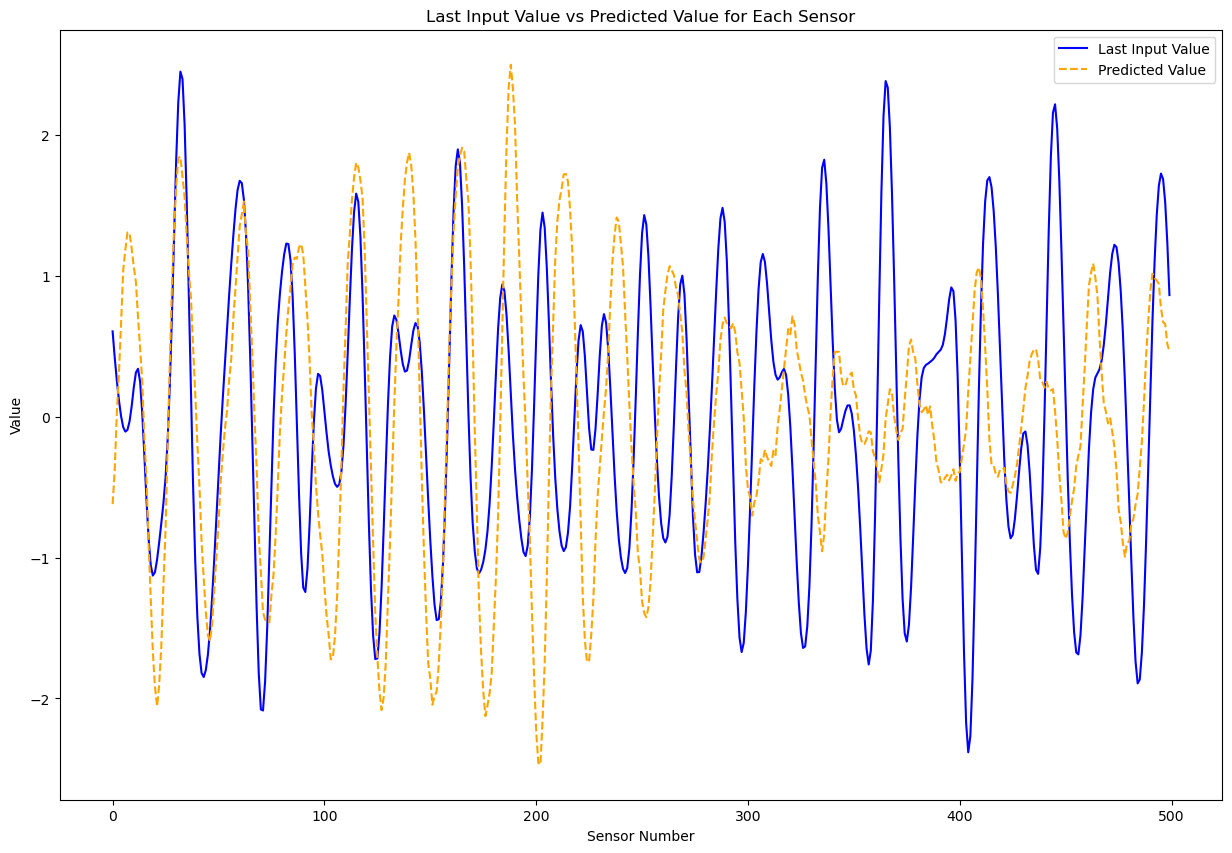

Overall Classification (0: Normal, 1: Abnormal): 0


In [81]:
import numpy as np
import pandas as pd
from scipy.io import arff
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed

# 데이터 로드
train_data, train_meta = arff.loadarff('./dataset/FordA_TRAIN.arff')
df_train = pd.DataFrame(train_data)

test_data, test_meta = arff.loadarff('./dataset/FordA_TEST.arff')
df_test = pd.DataFrame(test_data)

# 하이퍼파라미터 설정
num_sensors = 500  # 센서 개수
seq_len = 500  # 시계열 길이 (적절한 값으로 설정)

# 학습 데이터와 타겟 분리
x_train = df_train.iloc[:, :-1].values
y_train = df_train.iloc[:, -1].values
y_train[y_train == -1] = 0  # 이진 분류를 위해 타겟 값 조정

# 테스트 데이터와 타겟 분리
x_test = df_test.iloc[:, :-1].values
y_test = df_test.iloc[:, -1].values
y_test[y_test == -1] = 0  # 이진 분류를 위해 타겟 값 조정

# 데이터 스케일링
scalers = {}
x_train_scaled = np.zeros_like(x_train)
x_test_scaled = np.zeros_like(x_test)

for i in range(num_sensors):
    scalers[i] = StandardScaler()
    x_train_scaled[:, i] = scalers[i].fit_transform(x_train[:, i].reshape(-1, 1)).reshape(-1)
    x_test_scaled[:, i] = scalers[i].transform(x_test[:, i].reshape(-1, 1)).reshape(-1)

# 시계열 데이터로 변환
def reshape_data(data, seq_len, num_sensors):
    num_samples = data.shape[0] // seq_len * seq_len  # 가장 가까운 시계열 길이로 자르기
    data = data[:num_samples]
    reshaped_data = data.reshape(-1, seq_len, num_sensors)
    return reshaped_data

x_train_scaled = reshape_data(x_train_scaled, seq_len, num_sensors)
x_test_scaled = reshape_data(x_test_scaled, seq_len, num_sensors)

# 모델 정의
model_d = Sequential()
model_d.add(LSTM(units=100, return_sequences=True, input_shape=(seq_len, num_sensors)))
model_d.add(TimeDistributed(Dense(num_sensors)))  # 각 시점에서 500개의 값을 출력
model_d.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model_d.summary()

# 모델 가중치 로드
model_path = './LSTM_best.weights.h5'
model_d.load_weights(model_path)

# 예측 수행 및 시각화
def visualize_prediction(model, x_train, scalers, seq_len, num_sensors):
    example_sequence = x_train[-1, :, :]  # 학습 데이터의 마지막 시퀀스
    predicted_value = model.predict(example_sequence.reshape(1, seq_len, num_sensors))

    # 예측값을 원래 스케일로 되돌리기
    predicted_value_original = np.zeros_like(predicted_value.reshape(-1, num_sensors))
    for i in range(num_sensors):
        predicted_value_original[:, i] = scalers[i].inverse_transform(predicted_value[:, :, i].reshape(-1, 1)).reshape(-1)

    # 마지막 입력 값과 예측 값을 시각화
    plt.figure(figsize=(15, 10))
    plt.plot(range(num_sensors), example_sequence[-1, :], color='blue', label='Last Input Value')
    plt.plot(range(num_sensors), predicted_value_original[0, :], color='orange', linestyle='dashed', label='Predicted Value')
    plt.xlabel('Sensor Number')
    plt.ylabel('Value')
    plt.title('Last Input Value vs Predicted Value for Each Sensor')
    plt.legend()
    plt.show()

    # 모든 센서에 대해 정상/비정상 판단
    overall_classification = 1 if np.mean(predicted_value_original) >= 0.5 else 0
    print("Overall Classification (0: Normal, 1: Abnormal):", overall_classification)

# 예측 결과 시각화
visualize_prediction(model_d, x_train_scaled, scalers, seq_len, num_sensors)


# 모델 평가 시각화 (아직 미실행)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback
from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 모델 정의
model_d = Sequential()
model_d.add(LSTM(units=100, return_sequences=True, input_shape=(seq_len, num_sensors)))
model_d.add(TimeDistributed(Dense(num_sensors)))  # 각 시점에서 500개의 값을 출력
model_d.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model_d.summary()

# 배치 생성기 (x, y 데이터를 받아서 주어진 배치 크기로 분할하여 생성)
def batch_generator_s(x, y, seq_len, batch_size=32):
    num_samples = len(x)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_x = x[offset:offset+batch_size, :seq_len, :]
            batch_y = x[offset:offset+batch_size, :seq_len, :]  # 다음 값을 예측하므로 y도 동일
            yield batch_x, batch_y

# 데이터 준비
gen_train = batch_generator_s(x_train_scaled, y_train, seq_len)
gen_val = batch_generator_s(x_test_scaled, y_test, seq_len)

# 콜백 설정
NAME = f"td_fordA-{seq_len}seq_{int(time())}"  # 모델 이름 설정
tensorboard = TensorBoard(log_dir='Logs/{}'.format(NAME))  # 학습 로그 기록
checkp = ModelCheckpoint('./LSTM_best.weights.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')

class GetBest(Callback):
    def __init__(self, monitor='val_mae', verbose=1, mode='min'):
        super(GetBest, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.mode = mode
        self.best = np.Inf if mode == 'min' else -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if self.mode == 'min':
            if current < self.best:
                self.best = current
                if self.verbose:
                    print(f'Epoch {epoch+1}: {self.monitor} improved to {self.best:.5f}')
        else:
            if current > self.best:
                self.best = current
                if self.verbose:
                    print(f'Epoch {epoch+1}: {self.monitor} improved to {self.best:.5f}')

best = GetBest(monitor='val_mae', verbose=1, mode='min')
callbacks = [best, tensorboard, checkp]

# 모델 학습 및 history 객체 저장
history = model_d.fit(gen_train, epochs=60, steps_per_epoch=50, validation_data=gen_val, validation_steps=50, callbacks=callbacks)

# 학습 및 검증 손실 시각화
def plot_model_loss(history):
    plt.figure(figsize=(12, 8))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.show()

# 학습 및 검증 손실 시각화 호출
plot_model_loss(history)

# 모델 가중치 로드
model_path = './LSTM_best.weights.h5'
model_d.load_weights(model_path)

# 테스트 데이터 예측
predicted_values = model_d.predict(x_test_scaled)

# 각 시퀀스의 마지막 타임스텝을 사용하여 예측 수행
y_test_pred = predicted_values[:, -1, :]

# 평가지표 계산
mse = mean_squared_error(x_test_scaled[:, -1, :], y_test_pred)
mae = mean_absolute_error(x_test_scaled[:, -1, :], y_test_pred)

print("Mean Squared Error: {:.4f}".format(mse))
print("Mean Absolute Error: {:.4f}".format(mae))

# 시각화: 실제값과 예측값 비교
plt.figure(figsize=(12, 8))
plt.plot(x_test_scaled[-1, :, :].flatten(), label='Actual')
plt.plot(y_test_pred.flatten(), label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()
